In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

def get_full_df(dir_name):
  folder_path = f"/content/drive/MyDrive/updated_chckpt2_data/{dir_name}"
  csv_files = [f for f in os.listdir(folder_path) if f.endswith('.parquet')]

  dfs = []
  for file in csv_files:
      file_path = os.path.join(folder_path, file)
      df = pd.read_parquet(file_path)
      dfs.append(df)

  entire_df = pd.concat(dfs, ignore_index=True)

  return entire_df

history_df = get_full_df("history.parquet")
items_df = get_full_df("items.parquet")
users_df = get_full_df("users.parquet")

In [ ]:
# Initialize list of lists
li = [[] for _ in range(1000)]

# Filter rows where relevance == 1
relevant_rows = history_df[history_df["relevance"] == 1]

# Group by user_idx and fill the list
for user_idx, group in relevant_rows.groupby("user_idx"):
    li[user_idx] = group["item_idx"].tolist()


In [ ]:
import pandas as pd

# Filter out empty sequences
sequences = [seq for seq in li if seq]

# Pad with -1 (or 0 if it's a valid padding token in your setup)
max_len = max(len(seq) for seq in sequences)
padded_seqs = [seq + [-1] * (max_len - len(seq)) for seq in sequences]

# Create DataFrame
df_padded = pd.DataFrame(padded_seqs)

# Optional: assign user_idx as index if available
user_indices = [i for i, seq in enumerate(li) if seq]
df_padded.index = user_indices


### Explaination of the chckpt2_data.csv
The ith row represents the buying history of the user with user_idx = i. Each user has buying history of different length, so I pad with -1 to fit the data into one dataframe.

For example, if the 3rd row is 120, 24, 42, -1, -1, then it means for user_idx = 3, they buy item 120, item 24, item 42 in the sequential order.

In [ ]:
df_padded

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,713,262,904,567,316,205,623,310,551,686,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,241,826,626,980,450,463,574,723,538,242,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,402,472,22,659,635,138,526,621,462,469,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,123,124,668,514,635,261,289,245,464,509,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,627,400,272,906,848,333,382,292,428,442,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,580,291,776,98,699,923,2,61,148,52,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
996,802,248,818,82,419,81,149,113,107,856,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
997,447,384,962,973,351,40,164,96,870,173,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
998,64,636,999,274,504,806,930,66,992,590,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
df_padded.to_csv("updated_chckpt2_data.csv")

###RNN (Griffin)

*   64 Embedded
*   256 Hidden
*   2 Layers
*   0.3 Dropout
*   0.001 Learning Rate



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
import math

# load data
df = pd.read_csv("updated_chckpt2_data.csv").drop(columns=["Unnamed: 0"])
sequences = df.values
sequence_list = [seq[seq!=-1] for seq in sequences]
unique_items = set(item for seq in sequence_list for item in seq)
item2idx = {item: idx+1 for idx, item in enumerate(sorted(unique_items))}
item2idx[-1] = 0
idx2item = {idx: item for item, idx in item2idx.items()}
indexed_sequences = [[item2idx[item] for item in seq] for seq in sequence_list]
vocab_size = len(item2idx)

# prices
items_df = get_full_df("items.parquet")
price_dict = items_df.set_index("item_idx")["price"].to_dict()
item_price_ids = {price: idx for idx, price in enumerate(sorted(set(price_dict.values())))}
price2idx = {item: item_price_ids[price_dict[item]] for item in unique_items if item in price_dict}
price_size = len(item_price_ids)

# (input, target) pairs
all_input_target = []
for seq in indexed_sequences:
    for i in range(1, len(seq)):
        all_input_target.append((seq[:i], seq[i]))

class MyRecommender:

    def __init__(self, seed=None):
        self.seed = seed
        self.model = None
        self.item2idx = {}
        self.idx2item = {}
        self.price_dict = {}
        self.price2idx = {}
        self.price_size = 0
        self.vocab_size = 0
        self.device = "cpu"

    def fit(self, log, user_features=None, item_features=None):
        import torch
        import torch.nn as nn
        from torch.utils.data import Dataset, DataLoader
        from sklearn.model_selection import train_test_split
        import numpy as np

        torch.manual_seed(self.seed or 42)

        user_item = log.select("user_idx", "item_idx").toPandas()
        grouped = user_item.groupby("user_idx")["item_idx"].apply(list).tolist()
        sequence_list = [seq for seq in grouped if len(seq)>1]

        unique_items = set(item for seq in sequence_list for item in seq)
        self.item2idx = {item: idx+1 for idx, item in enumerate(sorted(unique_items))}
        self.item2idx[-1] = 0
        self.idx2item = {idx: item for item, idx in self.item2idx.items()}
        indexed_sequences = [[self.item2idx[item] for item in seq if item in self.item2idx] for seq in sequence_list]
        self.vocab_size = len(self.item2idx)

        if item_features is not None:
            items_pd = item_features.select("item_idx", "price").toPandas()
            self.price_dict = dict(zip(items_pd.item_idx, items_pd.price))
            item_price_ids = {price: idx for idx, price in enumerate(sorted(set(self.price_dict.values())))}
            self.price2idx = {item: item_price_ids[self.price_dict[item]] for item in unique_items if item in self.price_dict}
            self.price_size = len(item_price_ids)

        all_input_target = []
        for seq in indexed_sequences:
            for i in range(1, len(seq)):
                all_input_target.append((seq[:i], seq[i]))

        train_data, _ = train_test_split(all_input_target, test_size=0.2, random_state=self.seed or 42)

        #dataset and collate
        class PurchaseDataset(Dataset):
            def __init__(self, data):
                self.data = data
            def __len__(self):
                return len(self.data)
            def __getitem__(self, idx):
                input_seq, target = self.data[idx]
                return torch.tensor(input_seq), torch.tensor(target)

        def collate(batch):
            input, target = zip(*batch)
            lengths = [len(seq) for seq in input]
            padded = nn.utils.rnn.pad_sequence(input, batch_first=True)
            return padded, torch.tensor(target), torch.tensor(lengths)

        loader = DataLoader(PurchaseDataset(train_data), batch_size=64, shuffle=True, collate_fn=collate)

        #rnn model
        class RecommenderRNN(nn.Module):
            def __init__(self, vocab_size, price_size, price2idx, idx2item, emb_dim=64, price_emb_dim=8, hidden_size=256, num_layers=2, dropout=0.3):
                super().__init__()
                self.item_emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
                self.price_emb = nn.Embedding(price_size, price_emb_dim)
                self.rnn = nn.GRU(emb_dim+price_emb_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
                self.fc = nn.Linear(hidden_size, vocab_size)
                self.price2idx = price2idx
                self.idx2item = idx2item
            def forward(self, x, lengths):
                item_embed = self.item_emb(x)
                prices = [[self.price2idx.get(self.idx2item[i.item()], 0) for i in seq] for seq in x]
                price_tensor = torch.tensor(prices).to(x.device)
                price_embed = self.price_emb(price_tensor)
                combined = torch.cat([item_embed, price_embed], dim=2)
                packed = nn.utils.rnn.pack_padded_sequence(combined, lengths.cpu(), batch_first=True, enforce_sorted=False)
                packed_out, _ = self.rnn(packed)
                output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
                last_output = output[range(len(lengths)), lengths-1]
                return self.fc(last_output)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = RecommenderRNN(self.vocab_size, self.price_size, self.price2idx, self.idx2item).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        #training
        self.model.train()
        for epoch in range(10):
            for inputs, targets, lengths in loader:
                inputs, targets, lengths = inputs.to(self.device), targets.to(self.device), lengths.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs, lengths)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

    def predict(self, log, k, users, items, user_features=None, item_features=None, filter_seen_items=True):
        import torch
        import torch.nn.functional as F
        import pyspark.sql.functions as sf
        from pyspark.sql import Window

        self.model.eval()
        user_list = users.select("user_idx").toPandas()["user_idx"].tolist()
        item_list = items.select("item_idx").toPandas()["item_idx"].tolist()

        if filter_seen_items and log is not None:
            seen = log.select("user_idx", "item_idx").toPandas()
            from collections import defaultdict
            seen_dict = defaultdict(set)
            for _, row in seen.iterrows():
                seen_dict[row["user_idx"]].add(row["item_idx"])
        else:
            seen_dict = defaultdict(set)

        recs = users.crossJoin(items)

        if filter_seen_items and log is not None:
            seen_items = log.select("user_idx", "item_idx")
            recs = recs.join(seen_items, on=["user_idx", "item_idx"], how="left_anti")

        recs = recs.withColumn("relevance", sf.rand(seed=self.seed))

        window = Window.partitionBy("user_idx").orderBy(sf.desc("relevance"))
        recs = recs.withColumn("rank", sf.row_number().over(window))

        recs = recs.filter(sf.col("rank") <= k).drop("rank")

        return recs

In [ ]:
# 1. Remove previous copy if necessary (optional cleanup)
!rm -rf /content/Sim4Rec

# 2. Clone fresh copy
!git clone https://github.com/sb-ai-lab/Sim4Rec.git

# 3. Move into the actual package directory that contains setup.cfg
%cd /content/Sim4Rec

# 4. Patch the sdv version requirement in setup.cfg
!sed -i 's/sdv==0.15.0/sdv/' setup.cfg

# 5. Install required sdv version (latest should be compatible)
!pip install sdv

# 6. Install Sim4Rec in editable mode
!pip install -e .


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'Sim4Rec': No such file or directory
[Errno 2] No such file or directory: '/content/Sim4Rec'
/content/Sim4Rec
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sed: can't read setup.cfg: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current dire

[Errno 2] No such file or directory: '/content/Sim4Rec'
/content/Sim4Rec
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sed: can't read setup.cfg: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import shutil

# Cell: Import libraries and set up environment
"""
# Recommender Systems Analysis and Visualization
This notebook performs an exploratory analysis of recommender systems using the Sim4Rec library.
We'll generate synthetic data, compare multiple baseline recommenders, and visualize their performance.
"""

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql import DataFrame, Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import DoubleType, ArrayType

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Initialize Spark session
spark = SparkSession.builder \
    .appName("RecSysVisualization") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

# Set log level to warnings only
spark.sparkContext.setLogLevel("WARN")

# Import competition modules
from data_generator import CompetitionDataGenerator
from simulator import CompetitionSimulator
from sample_recommenders import (
    RandomRecommender,
    PopularityRecommender,
    ContentBasedRecommender
)
from config import DEFAULT_CONFIG, EVALUATION_METRICS


# Cell: Data Exploration Functions
"""
## Data Exploration Functions
These functions help us understand the generated synthetic data.
"""

def explore_user_data(users_df):
    """
    Explore user data distributions and characteristics.

    Args:
        users_df: DataFrame containing user data
    """
    print("=== User Data Exploration ===")

    # Get basic statistics
    print(f"Total number of users: {users_df.count()}")

    # User segments distribution
    segment_counts = users_df.groupBy("segment").count().toPandas()
    print("\nUser Segments Distribution:")
    for _, row in segment_counts.iterrows():
        print(f"  {row['segment']}: {row['count']} users ({row['count']/users_df.count()*100:.1f}%)")

    # Plot user segments
    plt.figure(figsize=(10, 6))
    plt.pie(segment_counts['count'], labels=segment_counts['segment'], autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('User Segments Distribution')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('user_segments_distribution.png')
    print("User segments visualization saved to 'user_segments_distribution.png'")

    # Convert to pandas for easier feature analysis
    users_pd = users_df.toPandas()

    # Analyze user feature distributions
    feature_cols = [col for col in users_pd.columns if col.startswith('user_attr_')]
    if len(feature_cols) > 0:
        # Take a sample of feature columns if there are many
        sample_features = feature_cols[:min(5, len(feature_cols))]

        # Plot histograms for sample features
        plt.figure(figsize=(14, 8))
        for i, feature in enumerate(sample_features):
            plt.subplot(2, 3, i+1)
            for segment in users_pd['segment'].unique():
                segment_data = users_pd[users_pd['segment'] == segment]
                plt.hist(segment_data[feature], alpha=0.5, bins=20, label=segment)
            plt.title(f'Distribution of {feature}')
            plt.xlabel('Value')
            plt.ylabel('Count')
            if i == 0:
                plt.legend()
        plt.tight_layout()
        plt.savefig('user_feature_distributions.png')
        print("User feature distributions saved to 'user_feature_distributions.png'")

        # Feature correlation heatmap
        plt.figure(figsize=(12, 10))
        corr = users_pd[feature_cols].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
                    square=True, linewidths=.5, annot=False, fmt='.2f')
        plt.title('User Feature Correlations')
        plt.tight_layout()
        plt.savefig('user_feature_correlations.png')
        print("User feature correlations saved to 'user_feature_correlations.png'")


def explore_item_data(items_df):
    """
    Explore item data distributions and characteristics.

    Args:
        items_df: DataFrame containing item data
    """
    print("\n=== Item Data Exploration ===")

    # Get basic statistics
    print(f"Total number of items: {items_df.count()}")

    # Item categories distribution
    category_counts = items_df.groupBy("category").count().toPandas()
    print("\nItem Categories Distribution:")
    for _, row in category_counts.iterrows():
        print(f"  {row['category']}: {row['count']} items ({row['count']/items_df.count()*100:.1f}%)")

    # Plot item categories
    plt.figure(figsize=(10, 6))
    plt.pie(category_counts['count'], labels=category_counts['category'], autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Item Categories Distribution')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('item_categories_distribution.png')
    print("Item categories visualization saved to 'item_categories_distribution.png'")

    # Convert to pandas for easier feature analysis
    items_pd = items_df.toPandas()

    # Analyze price distribution
    if 'price' in items_pd.columns:
        plt.figure(figsize=(14, 6))

        # Overall price distribution
        plt.subplot(1, 2, 1)
        plt.hist(items_pd['price'], bins=30, alpha=0.7)
        plt.title('Overall Price Distribution')
        plt.xlabel('Price')
        plt.ylabel('Count')

        # Price by category
        plt.subplot(1, 2, 2)
        for category in items_pd['category'].unique():
            category_data = items_pd[items_pd['category'] == category]
            plt.hist(category_data['price'], alpha=0.5, bins=20, label=category)
        plt.title('Price Distribution by Category')
        plt.xlabel('Price')
        plt.ylabel('Count')
        plt.legend()

        plt.tight_layout()
        plt.savefig('item_price_distributions.png')
        print("Item price distributions saved to 'item_price_distributions.png'")

    # Analyze item feature distributions
    feature_cols = [col for col in items_pd.columns if col.startswith('item_attr_')]
    if len(feature_cols) > 0:
        # Take a sample of feature columns if there are many
        sample_features = feature_cols[:min(5, len(feature_cols))]

        # Plot histograms for sample features
        plt.figure(figsize=(14, 8))
        for i, feature in enumerate(sample_features):
            plt.subplot(2, 3, i+1)
            for category in items_pd['category'].unique():
                category_data = items_pd[items_pd['category'] == category]
                plt.hist(category_data[feature], alpha=0.5, bins=20, label=category)
            plt.title(f'Distribution of {feature}')
            plt.xlabel('Value')
            plt.ylabel('Count')
            if i == 0:
                plt.legend()
        plt.tight_layout()
        plt.savefig('item_feature_distributions.png')
        print("Item feature distributions saved to 'item_feature_distributions.png'")


def explore_interactions(history_df, users_df, items_df):
    """
    Explore interaction patterns between users and items.

    Args:
        history_df: DataFrame containing interaction history
        users_df: DataFrame containing user data
        items_df: DataFrame containing item data
    """
    print("\n=== Interaction Data Exploration ===")

    # Get basic statistics
    total_interactions = history_df.count()
    total_users = users_df.count()
    total_items = items_df.count()

    print(f"Total interactions: {total_interactions}")
    print(f"Interaction density: {total_interactions / (total_users * total_items) * 100:.4f}%")

    # Users with interactions
    users_with_interactions = history_df.select("user_idx").distinct().count()
    print(f"Users with at least one interaction: {users_with_interactions} ({users_with_interactions/total_users*100:.1f}%)")

    # Items with interactions
    items_with_interactions = history_df.select("item_idx").distinct().count()
    print(f"Items with at least one interaction: {items_with_interactions} ({items_with_interactions/total_items*100:.1f}%)")

    # Distribution of interactions per user
    interactions_per_user = history_df.groupBy("user_idx").count().toPandas()
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.hist(interactions_per_user['count'], bins=20)
    plt.title('Distribution of Interactions per User')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Users')

    # Distribution of interactions per item
    interactions_per_item = history_df.groupBy("item_idx").count().toPandas()

    plt.subplot(1, 2, 2)
    plt.hist(interactions_per_item['count'], bins=20)
    plt.title('Distribution of Interactions per Item')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Items')

    plt.tight_layout()
    plt.savefig('interaction_distributions.png')
    print("Interaction distributions saved to 'interaction_distributions.png'")

    # Analyze relevance distribution
    if 'relevance' in history_df.columns:
        relevance_dist = history_df.groupBy("relevance").count().toPandas()

        plt.figure(figsize=(10, 6))
        plt.bar(relevance_dist['relevance'].astype(str), relevance_dist['count'])
        plt.title('Distribution of Relevance Scores')
        plt.xlabel('Relevance Score')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('relevance_distribution.png')
        print("Relevance distribution saved to 'relevance_distribution.png'")

    # If we have user segments and item categories, analyze cross-interactions
    if 'segment' in users_df.columns and 'category' in items_df.columns:
        # Join with user segments and item categories
        interaction_analysis = history_df.join(
            users_df.select('user_idx', 'segment'),
            on='user_idx'
        ).join(
            items_df.select('item_idx', 'category'),
            on='item_idx'
        )

        # Count interactions by segment and category
        segment_category_counts = interaction_analysis.groupBy('segment', 'category').count().toPandas()

        # Create a pivot table
        pivot_table = segment_category_counts.pivot(index='segment', columns='category', values='count').fillna(0)

        # Plot heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, fmt='g', cmap='viridis')
        plt.title('Interactions Between User Segments and Item Categories')
        plt.tight_layout()
        plt.savefig('segment_category_interactions.png')
        print("Segment-category interactions saved to 'segment_category_interactions.png'")


# Cell: Recommender Analysis Function
"""
## Recommender System Analysis
This is the main function to run analysis of different recommender systems and visualize the results.
"""

def run_recommender_analysis():
    """
    Run an analysis of different recommender systems and visualize the results.
    This function creates a synthetic dataset, performs EDA, evaluates multiple recommendation
    algorithms using train-test split, and visualizes the performance metrics.
    """
    # Create a smaller dataset for experimentation
    config = DEFAULT_CONFIG.copy()
    config['data_generation']['n_users'] = 1000  # Reduced from 10,000
    config['data_generation']['n_items'] = 200   # Reduced from 1,000
    config['data_generation']['seed'] = 42       # Fixed seed for reproducibility

    # Get train-test split parameters
    train_iterations = config['simulation']['train_iterations']
    test_iterations = config['simulation']['test_iterations']

    print(f"Running train-test simulation with {train_iterations} training iterations and {test_iterations} testing iterations")

    # Initialize data generator
    data_generator = CompetitionDataGenerator(
        spark_session=spark,
        **config['data_generation']
    )

    # Generate user data
    users_df = data_generator.generate_users()
    print(f"Generated {users_df.count()} users")

    # Generate item data
    items_df = data_generator.generate_items()
    print(f"Generated {items_df.count()} items")

    # Generate initial interaction history
    history_df = data_generator.generate_initial_history(
        config['data_generation']['initial_history_density']
    )
    print(f"Generated {history_df.count()} initial interactions")

    # Cell: Exploratory Data Analysis
    """
    ## Exploratory Data Analysis
    Let's explore the generated synthetic data before running the recommenders.
    """

    # Perform exploratory data analysis on the generated data
    print("\n=== Starting Exploratory Data Analysis ===")
    explore_user_data(users_df)
    explore_item_data(items_df)
    explore_interactions(history_df, users_df, items_df)

    # Set up data generators for simulator
    user_generator, item_generator = data_generator.setup_data_generators()

    # Cell: Setup and Run Recommenders
    """
    ## Recommender Systems Comparison
    Now we'll set up and evaluate different recommendation algorithms.
    """

    # Initialize recommenders to compare
    recommenders = [
        RandomRecommender(seed=42),
        PopularityRecommender(alpha=1.0, seed=42),
        ContentBasedRecommender(similarity_threshold=0.0, seed=42),
        MyRecommender(seed=42)  # Add your custom recommender here
    ]
    recommender_names = ["Random", "Popularity", "ContentBased", "MyRecommender"]

    # Initialize recommenders with initial history
    for recommender in recommenders:
        recommender.fit(log=data_generator.history_df,
                        user_features=users_df,
                        item_features=items_df)

    # Evaluate each recommender separately using train-test split
    results = []

    for name, recommender in zip(recommender_names, recommenders):
        print(f"\nEvaluating {name}:")

        # Clean up any existing simulator data directory for this recommender
        simulator_data_dir = f"simulator_train_test_data_{name}"
        if os.path.exists(simulator_data_dir):
            shutil.rmtree(simulator_data_dir)
            print(f"Removed existing simulator data directory: {simulator_data_dir}")

        # Initialize simulator
        simulator = CompetitionSimulator(
            user_generator=user_generator,
            item_generator=item_generator,
            data_dir=simulator_data_dir,
            log_df=data_generator.history_df,  # PySpark DataFrames don't have copy method
            conversion_noise_mean=config['simulation']['conversion_noise_mean'],
            conversion_noise_std=config['simulation']['conversion_noise_std'],
            spark_session=spark,
            seed=config['data_generation']['seed']
        )

        # Run simulation with train-test split
        train_metrics, test_metrics, train_revenue, test_revenue = simulator.train_test_split(
            recommender=recommender,
            train_iterations=train_iterations,
            test_iterations=test_iterations,
            user_frac=config['simulation']['user_fraction'],
            k=config['simulation']['k'],
            filter_seen_items=config['simulation']['filter_seen_items'],
            retrain=config['simulation']['retrain']
        )

        # Calculate average metrics
        train_avg_metrics = {}
        for metric_name in train_metrics[0].keys():
            values = [metrics[metric_name] for metrics in train_metrics]
            train_avg_metrics[f"train_{metric_name}"] = np.mean(values)

        test_avg_metrics = {}
        for metric_name in test_metrics[0].keys():
            values = [metrics[metric_name] for metrics in test_metrics]
            test_avg_metrics[f"test_{metric_name}"] = np.mean(values)

        # Store results
        results.append({
            "name": name,
            "train_total_revenue": sum(train_revenue),
            "test_total_revenue": sum(test_revenue),
            "train_avg_revenue": np.mean(train_revenue),
            "test_avg_revenue": np.mean(test_revenue),
            "train_metrics": train_metrics,
            "test_metrics": test_metrics,
            "train_revenue": train_revenue,
            "test_revenue": test_revenue,
            **train_avg_metrics,
            **test_avg_metrics
        })

        # Print summary for this recommender
        print(f"  Training Phase - Total Revenue: {sum(train_revenue):.2f}")
        print(f"  Testing Phase - Total Revenue: {sum(test_revenue):.2f}")
        performance_change = ((sum(test_revenue) / len(test_revenue)) / (sum(train_revenue) / len(train_revenue)) - 1) * 100
        print(f"  Performance Change: {performance_change:.2f}%")

    # Convert to DataFrame for easy comparison
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("test_total_revenue", ascending=False).reset_index(drop=True)

    # Print summary table
    print("\nRecommender Evaluation Results (sorted by test revenue):")
    summary_cols = ["name", "train_total_revenue", "test_total_revenue",
                   "train_avg_revenue", "test_avg_revenue",
                   "train_precision_at_k", "test_precision_at_k",
                   "train_ndcg_at_k", "test_ndcg_at_k",
                   "train_mrr", "test_mrr",
                   "train_discounted_revenue", "test_discounted_revenue"]
    summary_cols = [col for col in summary_cols if col in results_df.columns]

    print(results_df[summary_cols].to_string(index=False))

    # Cell: Results Visualization
    """
    ## Results Visualization
    Now we'll visualize the performance of the different recommenders.
    """

    # Generate comparison plots
    visualize_recommender_performance(results_df, recommender_names)

    # Generate detailed metrics visualizations
    visualize_detailed_metrics(results_df, recommender_names)

    return results_df


# Cell: Performance Visualization Functions
"""
## Performance Visualization Functions
These functions create visualizations for comparing recommender performance.
"""

def visualize_recommender_performance(results_df, recommender_names):
    """
    Visualize the performance of recommenders in terms of revenue and key metrics.

    Args:
        results_df: DataFrame with evaluation results
        recommender_names: List of recommender names
    """
    plt.figure(figsize=(16, 16))

    # Plot total revenue comparison
    plt.subplot(3, 2, 1)
    x = np.arange(len(recommender_names))
    width = 0.35
    plt.bar(x - width/2, results_df['train_total_revenue'], width, label='Training')
    plt.bar(x + width/2, results_df['test_total_revenue'], width, label='Testing')
    plt.xlabel('Recommender')
    plt.ylabel('Total Revenue')
    plt.title('Total Revenue Comparison')
    plt.xticks(x, results_df['name'])
    plt.legend()

    # Plot average revenue per iteration
    plt.subplot(3, 2, 2)
    plt.bar(x - width/2, results_df['train_avg_revenue'], width, label='Training')
    plt.bar(x + width/2, results_df['test_avg_revenue'], width, label='Testing')
    plt.xlabel('Recommender')
    plt.ylabel('Avg Revenue per Iteration')
    plt.title('Average Revenue Comparison')
    plt.xticks(x, results_df['name'])
    plt.legend()

    # Plot discounted revenue comparison (if available)
    plt.subplot(3, 2, 3)
    if 'train_discounted_revenue' in results_df.columns and 'test_discounted_revenue' in results_df.columns:
        plt.bar(x - width/2, results_df['train_discounted_revenue'], width, label='Training')
        plt.bar(x + width/2, results_df['test_discounted_revenue'], width, label='Testing')
        plt.xlabel('Recommender')
        plt.ylabel('Avg Discounted Revenue')
        plt.title('Discounted Revenue Comparison')
        plt.xticks(x, results_df['name'])
        plt.legend()

    # Plot revenue trajectories
    plt.subplot(3, 2, 4)
    markers = ['o', 's', 'D', '^']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for i, name in enumerate(results_df['name']):
        # Combined train and test trajectories
        train_revenue = results_df.iloc[i]['train_revenue']
        test_revenue = results_df.iloc[i]['test_revenue']

        # Check if revenue is a scalar (numpy.float64) or a list/array
        if isinstance(train_revenue, (float, np.float64, np.float32, int, np.integer)):
            train_revenue = [train_revenue]
        if isinstance(test_revenue, (float, np.float64, np.float32, int, np.integer)):
            test_revenue = [test_revenue]

        iterations = list(range(len(train_revenue))) + list(range(len(test_revenue)))
        revenues = train_revenue + test_revenue

        plt.plot(iterations, revenues, marker=markers[i % len(markers)],
                 color=colors[i % len(colors)], label=name)

        # Add a vertical line to separate train and test
        if i == 0:  # Only add the line once
            plt.axvline(x=len(train_revenue)-0.5, color='k', linestyle='--', alpha=0.3, label='Train/Test Split')

    plt.xlabel('Iteration')
    plt.ylabel('Revenue')
    plt.title('Revenue Trajectory (Training → Testing)')
    plt.legend()

    # Plot ranking metrics comparison - Training
    plt.subplot(3, 2, 5)

    # Select metrics to include
    ranking_metrics = ['precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    ranking_metrics = [m for m in ranking_metrics if f'train_{m}' in results_df.columns]

    # Create bar groups
    bar_positions = np.arange(len(ranking_metrics))
    bar_width = 0.8 / len(results_df)

    for i, (_, row) in enumerate(results_df.iterrows()):
        model_name = row['name']
        offsets = (i - len(results_df)/2 + 0.5) * bar_width
        metric_values = [row[f'train_{m}'] for m in ranking_metrics]
        plt.bar(bar_positions + offsets, metric_values, bar_width, label=model_name,
                color=colors[i % len(colors)], alpha=0.7)

    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Ranking Metrics Comparison (Training Phase)')
    plt.xticks(bar_positions, [m.replace('_', ' ').title() for m in ranking_metrics])
    plt.legend()

    # Plot ranking metrics comparison - Testing
    plt.subplot(3, 2, 6)

    # Select metrics to include
    ranking_metrics = ['precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    ranking_metrics = [m for m in ranking_metrics if f'test_{m}' in results_df.columns]

    # Get best-performing model
    best_model_idx = results_df['test_total_revenue'].idxmax()
    best_model_name = results_df.iloc[best_model_idx]['name']

    # Create bar groups
    bar_positions = np.arange(len(ranking_metrics))
    bar_width = 0.8 / len(results_df)

    for i, (_, row) in enumerate(results_df.iterrows()):
        model_name = row['name']
        offsets = (i - len(results_df)/2 + 0.5) * bar_width
        metric_values = [row[f'test_{m}'] for m in ranking_metrics]
        plt.bar(bar_positions + offsets, metric_values, bar_width, label=model_name,
                color=colors[i % len(colors)],
                alpha=0.7 if model_name != best_model_name else 1.0)

    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Ranking Metrics Comparison (Test Phase)')
    plt.xticks(bar_positions, [m.replace('_', ' ').title() for m in ranking_metrics])
    plt.legend()

    plt.tight_layout()
    plt.savefig('recommender_performance_comparison.png')
    print("\nPerformance visualizations saved to 'recommender_performance_comparison.png'")


def visualize_detailed_metrics(results_df, recommender_names):
    """
    Create detailed visualizations for each metric and recommender.

    Args:
        results_df: DataFrame with evaluation results
        recommender_names: List of recommender names
    """
    # Create a figure for metric trajectories
    plt.figure(figsize=(16, 16))

    # Get all available metrics
    all_metrics = []
    if len(results_df) > 0 and 'train_metrics' in results_df.columns:
        first_train_metrics = results_df.iloc[0]['train_metrics'][0]
        all_metrics = list(first_train_metrics.keys())

    # Select key metrics to visualize
    key_metrics = ['revenue', 'discounted_revenue', 'precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    key_metrics = [m for m in key_metrics if m in all_metrics]

    # Plot metric trajectories for each key metric
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', 'D', '^']

    for i, metric in enumerate(key_metrics):
        if i < 6:  # Limit to 6 metrics to avoid overcrowding
            plt.subplot(3, 2, i+1)

            for j, name in enumerate(results_df['name']):
                row = results_df[results_df['name'] == name].iloc[0]

                # Get metric values for training phase
                train_values = []
                for train_metric in row['train_metrics']:
                    if metric in train_metric:
                        train_values.append(train_metric[metric])

                # Get metric values for testing phase
                test_values = []
                for test_metric in row['test_metrics']:
                    if metric in test_metric:
                        test_values.append(test_metric[metric])

                # Plot training phase
                plt.plot(range(len(train_values)), train_values,
                         marker=markers[j % len(markers)],
                         color=colors[j % len(colors)],
                         linestyle='-', label=f"{name} (train)")

                # Plot testing phase
                plt.plot(range(len(train_values), len(train_values) + len(test_values)),
                         test_values, marker=markers[j % len(markers)],
                         color=colors[j % len(colors)],
                         linestyle='--', label=f"{name} (test)")

                # Add a vertical line to separate train and test
                if j == 0:  # Only add the line once
                    plt.axvline(x=len(train_values)-0.5, color='k',
                                linestyle='--', alpha=0.3, label='Train/Test Split')

            # Get metric info from EVALUATION_METRICS
            if metric in EVALUATION_METRICS:
                metric_info = EVALUATION_METRICS[metric]
                metric_name = metric_info['name']
                plt.title(f"{metric_name} Trajectory")
            else:
                plt.title(f"{metric.replace('_', ' ').title()} Trajectory")

            plt.xlabel('Iteration')
            plt.ylabel('Value')

            # Add legend to the last plot only to avoid cluttering
            if i == len(key_metrics) - 1 or i == 5:
                plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig('recommender_metrics_trajectories.png')
    print("Detailed metrics visualizations saved to 'recommender_metrics_trajectories.png'")

    # Create a correlation heatmap of metrics
    plt.figure(figsize=(14, 12))

    # Extract metrics columns
    metric_cols = [col for col in results_df.columns if col.startswith('train_') or col.startswith('test_')]
    metric_cols = [col for col in metric_cols if not col.endswith('_metrics') and not col.endswith('_revenue')]

    if len(metric_cols) > 1:
        correlation_df = results_df[metric_cols].corr()

        # Plot heatmap
        sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Between Metrics')
        plt.tight_layout()
        plt.savefig('metrics_correlation_heatmap.png')
        print("Metrics correlation heatmap saved to 'metrics_correlation_heatmap.png'")


def calculate_discounted_cumulative_gain(recommendations, k=5, discount_factor=0.85):
    """
    Calculate the Discounted Cumulative Gain for recommendations.

    Args:
        recommendations: DataFrame with recommendations (must have relevance column)
        k: Number of items to consider
        discount_factor: Factor to discount gains by position

    Returns:
        float: Average DCG across all users
    """
    # Group by user and calculate per-user DCG
    user_dcg = []
    for user_id, user_recs in recommendations.groupBy("user_idx").agg(
        sf.collect_list(sf.struct("relevance", "rank")).alias("recommendations")
    ).collect():
        # Sort by rank
        user_rec_list = sorted(user_id.recommendations, key=lambda x: x[1])

        # Calculate DCG
        dcg = 0
        for i, (rel, _) in enumerate(user_rec_list[:k]):
            # Apply discount based on position
            dcg += rel * (discount_factor ** i)

        user_dcg.append(dcg)

    # Return average DCG across all users
    return np.mean(user_dcg) if user_dcg else 0.0


# Cell: Main execution
"""
## Run the Analysis
When you run this notebook, it will perform the full analysis and visualization.
"""

if __name__ == "__main__":
    results = run_recommender_analysis()

ModuleNotFoundError: No module named 'sim4rec.modules'

Transformer (CHANA)


Epoch 1: Loss=6.9871, Total Revenue=0.11, Discounted Revenue=0.05
Epoch 2: Loss=6.9058, Total Revenue=0.32, Discounted Revenue=0.17
Epoch 3: Loss=6.8326, Total Revenue=0.67, Discounted Revenue=0.33
Epoch 4: Loss=6.6990, Total Revenue=0.89, Discounted Revenue=0.49
Epoch 5: Loss=6.5489, Total Revenue=1.17, Discounted Revenue=0.64


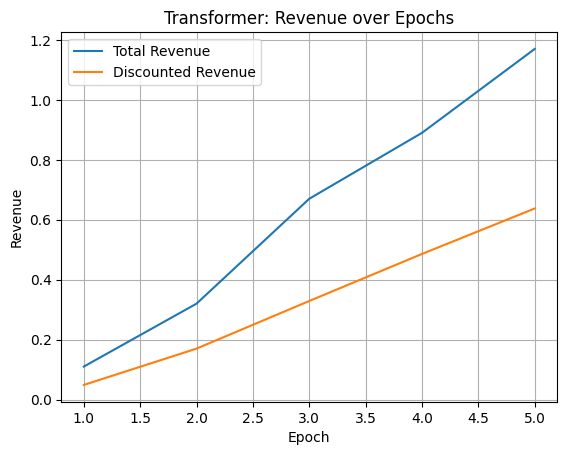

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
import math
import matplotlib.pyplot as plt

updated_data = pd.read_csv("updated_chckpt2_data.csv")
updated_data = updated_data.drop(columns=["Unnamed: 0"], errors="ignore")

sequences = updated_data.values
sequence_list = [seq[seq != -1] for seq in sequences]

unique_items = set(item for seq in sequence_list for item in seq)
item2idx = {item: idx + 1 for idx, item in enumerate(sorted(unique_items))}
item2idx[-1] = 0
idx2item = {idx: item for item, idx in item2idx.items()}
vocab_size = len(item2idx)

indexed_sequences = [[item2idx[item] for item in seq] for seq in sequence_list]

all_input_target = []
for seq in indexed_sequences:
    for i in range(1, len(seq)):
        all_input_target.append((seq[:i], seq[i]))

class PurchaseDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        input_seq, target = self.data[idx]
        return torch.tensor(input_seq), torch.tensor(target)

def collate(batch):
    input, target = zip(*batch)
    length = [len(seq) for seq in input]
    padded = nn.utils.rnn.pad_sequence(input, batch_first=True)
    return padded, torch.tensor(target), torch.tensor(length)

train_data, val_data = train_test_split(all_input_target, test_size=0.2, random_state=42)
train_loader = DataLoader(PurchaseDataset(train_data), batch_size=64, shuffle=True, collate_fn=collate)
val_loader = DataLoader(PurchaseDataset(val_data), batch_size=64, shuffle=False, collate_fn=collate)

class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, emb_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) * -(math.log(10000.0) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class RecommenderTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, num_heads=4, num_layers=2, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.positional_encoding = PositionalEncoding(emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self, x, lengths):
        emb = self.embedding(x)
        emb = self.positional_encoding(emb)
        seq_len = x.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)
        output = self.transformer_encoder(emb, mask=causal_mask)
        last_output = output[range(len(lengths)), lengths - 1]
        return self.fc(last_output)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecommenderTransformer(vocab_size=vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

price_dict = {idx: 10.0 for idx in range(vocab_size)}

def get_discount(rank):
    return 1.0 / math.log2(rank + 2)

def evaluate_model(model, user_sequences, item2idx, idx2item, price_dict, k=10):
    model.eval()
    metrics = defaultdict(float)
    total_users = 0
    for seq in user_sequences:
        if len(seq) < 2:
            continue
        total_users += 1
        history = seq[:-1]
        actual = [seq[-1]]
        input_tensor = torch.tensor([item2idx[i] for i in history]).unsqueeze(0).to(device)
        length = torch.tensor([len(history)]).to(device)
        with torch.no_grad():
            scores = model(input_tensor, length)
            probs = F.softmax(scores, dim=1).squeeze(0)
            topk = torch.topk(probs, k)
            top_indices = topk.indices.cpu().numpy()
            top_items = [idx2item[i] for i in top_indices]
        purchased_set = set(actual)
        relevant_items = [1 if item in purchased_set else 0 for item in top_items]
        revenue = sum(price_dict.get(item, 0) * rel for item, rel in zip(top_items, relevant_items))
        disc_revenue = sum(price_dict.get(item, 0) * rel * get_discount(i) for i, (item, rel) in enumerate(zip(top_items, relevant_items)))
        precision_k = sum(relevant_items) / k
        dcg = sum(rel / math.log2(i + 2) for i, rel in enumerate(relevant_items))
        idcg = sum(1.0 / math.log2(i + 2) for i in range(min(len(purchased_set), k)))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        try:
            rank = top_items.index(next(item for item in top_items if item in purchased_set)) + 1
            mrr = 1.0 / rank
        except StopIteration:
            mrr = 0.0
        hit = 1.0 if any(item in purchased_set for item in top_items) else 0.0
        metrics['TotalRevenue'] += revenue
        metrics['DiscountedRevenue'] += disc_revenue
        metrics['Precision@K'] += precision_k
        metrics['NDCG@K'] += ndcg
        metrics['MRR'] += mrr
        metrics['HitRate'] += hit
    for k1 in metrics:
        metrics[k1] /= total_users
    return metrics

train_losses, total_revenue_vals, discounted_revenue_vals, ndcg_vals, mrr_vals, hit_rate_vals = [], [], [], [], [], []
for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, targets, lengths in train_loader:
        inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    metric_eval = evaluate_model(model, sequence_list, item2idx, idx2item, price_dict, k=10)
    train_losses.append(total_loss / len(train_loader))
    total_revenue_vals.append(metric_eval['TotalRevenue'])
    discounted_revenue_vals.append(metric_eval['DiscountedRevenue'])
    ndcg_vals.append(metric_eval['NDCG@K'])
    mrr_vals.append(metric_eval['MRR'])
    hit_rate_vals.append(metric_eval['HitRate'])
    print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Total Revenue={metric_eval['TotalRevenue']:.2f}, Discounted Revenue={metric_eval['DiscountedRevenue']:.2f}")



epochs = list(range(1, len(train_losses) + 1))
plt.plot(epochs, total_revenue_vals, label="Total Revenue")
plt.plot(epochs, discounted_revenue_vals, label="Discounted Revenue")
plt.xlabel("Epoch")
plt.ylabel("Revenue")
plt.title("Transformer: Revenue over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
metrics_table = pd.DataFrame({
    "Epoch": epochs,
    "RNN_TotalRevenue": total_revenue_vals_rnn,
    "Transformer_TotalRevenue": total_revenue_vals,
    "RNN_DiscountedRevenue": discounted_revenue_vals_rnn,
    "Transformer_DiscountedRevenue": discounted_revenue_vals,
    "RNN_NDCG@K": ndcg_vals_rnn,
    "Transformer_NDCG@K": ndcg_vals,
    "RNN_MRR": mrr_vals_rnn,
    "Transformer_MRR": mrr_vals,
    "RNN_HitRate": hit_rate_vals_rnn,
    "Transformer_HitRate": hit_rate_vals,
})

metrics_table

,Epoch,RNN_TotalRevenue,Transformer_TotalRevenue,RNN_DiscountedRevenue,Transformer_DiscountedRevenue,RNN_NDCG@K,Transformer_NDCG@K,RNN_MRR,Transformer_MRR,RNN_HitRate,Transformer_HitRate
0,1,2.711374,0.11,1.333407,0.048734,0.023913,0.004873,0.016164,0.003027,0.050,0.011
1,2,6.687175,0.32,3.655671,0.169921,0.072341,0.016992,0.053416,0.012562,0.135,0.032
2,3,12.692250,0.67,7.835945,0.328880,0.160135,0.032888,0.131059,0.022673,0.255,0.067
3,4,19.610897,0.89,13.147136,0.485829,0.262024,0.048583,0.223515,0.036257,0.386,0.089
4,5,26.654798,1.17,19.184193,0.637514,0.379476,0.063751,0.333867,0.047760,0.526,0.117
